# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [106]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import libraries

In [2]:
from __future__ import print_function
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg 
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [26]:
ct_shape.crs = from_epsg(4326) #epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s mi^2'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 mi^2


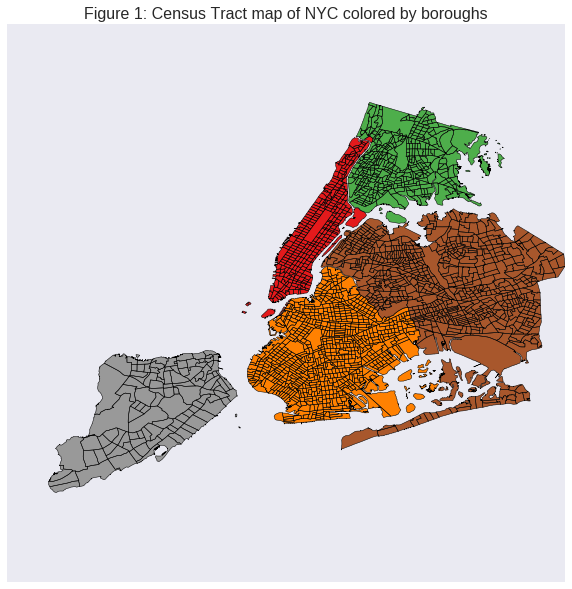

In [76]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode', alpha = 1, linewidth = 0.5, ax = ax)
plt.title("Figure 1: Census Tract map of NYC colored by boroughs", fontsize = 16)

## Figure 1: 
### The above figure plots of map of the five boroughs of New York city. Red, green, brown, orange, and gray represent Manhattan, the Bronx, Queens, Brooklyn, and Staten Island, respectively.

### Map NYC Population density

#### Load Census Data for 2010

In [15]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [16]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

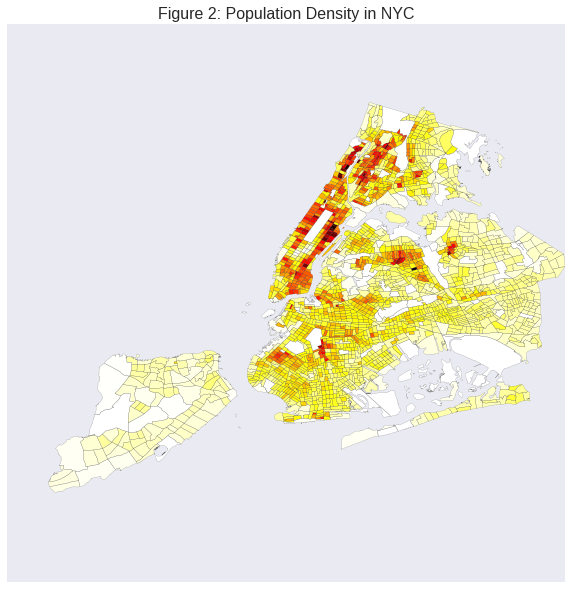

In [78]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column = 'SE_T002_002', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 2: Population Density in NYC", fontsize = 16)

## Figure 2:
### The above figure plots a map of New York City showing population density using a heat scale. Darker red indicates a higher population densities in that census tract, while lighter colors indicate lower densities. Population density appears highest in Manhattan around Central Park (particularly the east side) and in parts of the Bronx, while Staten Island appears to have the lowest population densities in their census tracts.  

## Explore CitiBike data

### Load CitiBike data

In [18]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Analysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


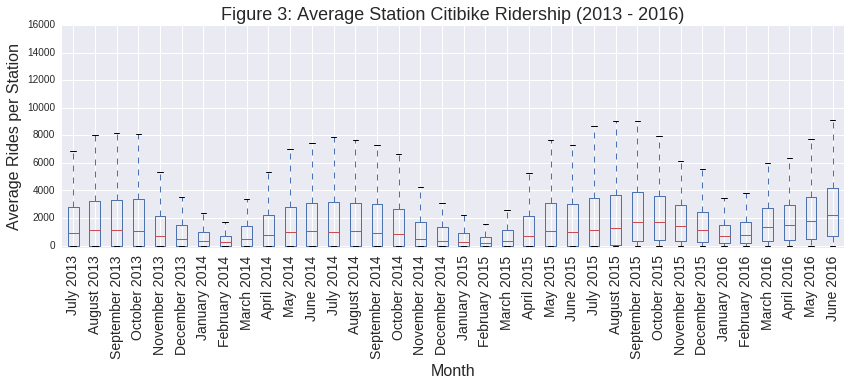

In [86]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize = (14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize = (15,7), ax = ax, rot = 90);
ax.set_ylim([-200,16000])
ax.set_title('Figure 3: Average Station Citibike Ridership (2013 - 2016)', fontsize = 18)
ax.set_ylabel('Average Rides per Station', fontsize = 16)
ax.set_xlabel('Month', fontsize = 16)

## Figure 3:
### The above plot shows a time series for Citibike data in NYC by month from 2013 to 2016. Each month's value is the average number of rides across all stations. Each month includes a boxplot showing the median (red line), the first and third quartiles (bottom and top of box), as well as the minimum and maximum rides at any station (the ends of the dashed lines). We can see a clear periodic trend of ridership increasing during the summer months and dropping during the winter.

#### Seasonal Decomposition

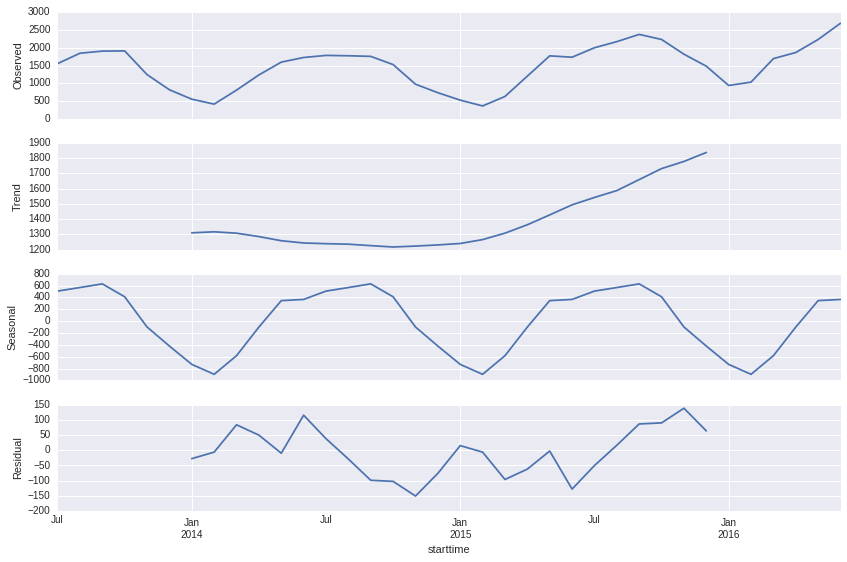

In [94]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_new = df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize'] = (12,8)
resplot = res.plot()

## Figure 4: Seasonal Decomposition of Citibike Data in NYC
### The above set of figures show a data decomposition of observed Citibike ridership data over time. The x axis shows time in 6 month intervals from 2013 to 2016, and the y axis numbers represent the average rides per station, as in Figure 3. The first plot shows the smoothed trends from Figure 3, with a clear seasonal periodicity appearing. The next three plots beneath this break the observed data into the following components: the trend in ridership, seasonal differences, and any residual data. The residual values fall at or less than 150 average rides from 0, much smaller than the overal signal we are seeing, which is a good sign that the trend and the seasonal components are actually creating the observed trend instead of change. The trend line appears to be increasing, indicating ridership on average is likely going up, while the seasonal component shows a clear increase in summer and decrease in winter. 

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [21]:
station_id = DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [22]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [29]:
a = []
""" check for each citibike stations to see what CT they are belong to 
"""
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
station_id['BoroCT2010'] = a

In [30]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [31]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve'] = df_bike_monthly.sum()

In [32]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


### Add the monthly average rides to the CT shapefile 

In [33]:
temp = station_id[['MonthlyAve']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0, inplace = True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


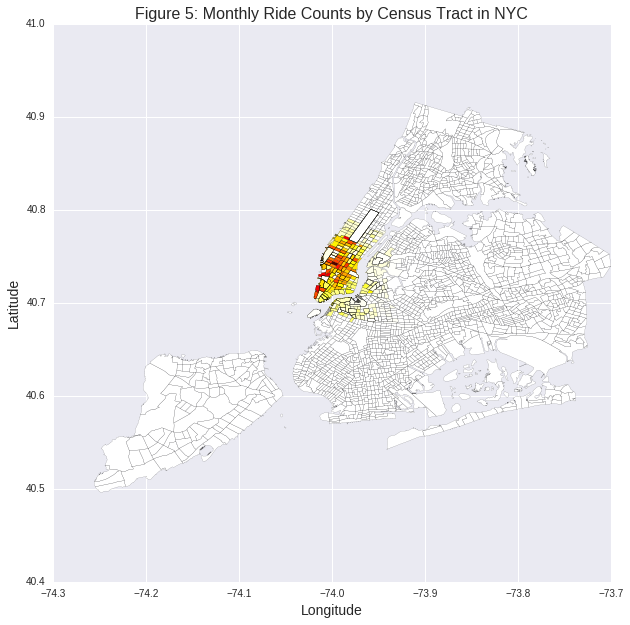

In [96]:
f, ax = plt.subplots(figsize = (10,10))
ct_shape_MonthlyAve.plot(column = 'MonthlyAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 5: Monthly Ride Counts by Census Tract in NYC", fontsize = 16)
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)

## Figure 5:
### The above plot shows the average monthly ride counts by census tract in all of NYC. The data is in a heat color scale, where darker colors indicate more rides and lighter colors less. It is clear that there are fewer riders outside of Manhattan than within, where most of the rides are clustering in the southern part of this borough. 

### Removing the CTs that are out of zoom boundries

In [35]:
ct_shape_MonthlyAve_Zoom = (ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x > -74.1 and c.x < -73.92 and c.y > 40.65 and c.y < 40.8)])

In [44]:
shape_len = len(ct_shape)
temp_len = len(temp.MonthlyAve)

print ('Total number of CTs:', shape_len)
print ('Number of zoomed CTs:', temp_len)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

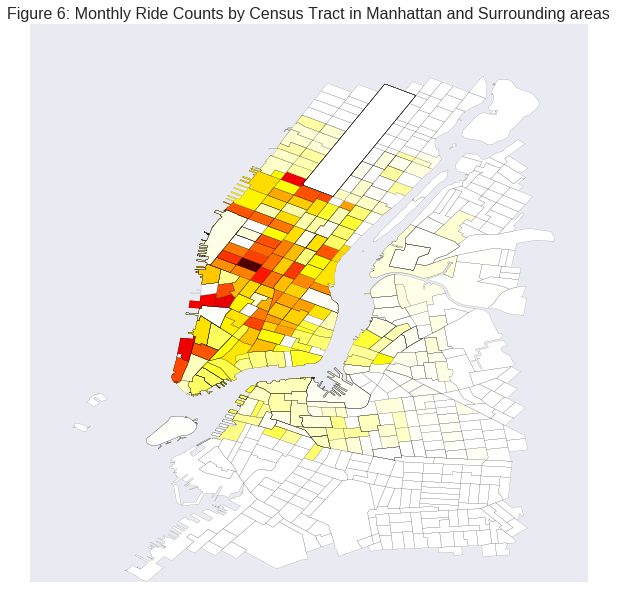

In [97]:
f, ax = plt.subplots(figsize = (10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column = 'MonthlyAve', colormap = 'hot_r', alpha = 1, linewidth = 0.1, ax = ax)
plt.title("Figure 6: Monthly Ride Counts by Census Tract in Manhattan and Surrounding Areas", fontsize = 16)
plt.xlabel('Longitude', fontsize = 14)
plt.ylabel('Latitude', fontsize = 14)

## Figure 6:
### The above plot shows the zoomed-in portion of Figure 5, displaying only Manhattan and some of the surrounding census tracts of nearby neighborhoods in order to look more closely at the higher ridership tracts. From this visualization, we can see that parts of midtown/southern midtown and some key areas along the southwestern piers (likely those with views of the harbor/Lady Liberty) have the highest monthly ride counts. 

### Export Shapefile CTs in the CitiBike Zone

In [46]:
path = 'Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [47]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [48]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [49]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [50]:
Wmatrix, ids = qW_CT.full()

In [51]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [52]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [53]:
MonthlyRide = ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag = ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [54]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

#### Map the monthly rides lag

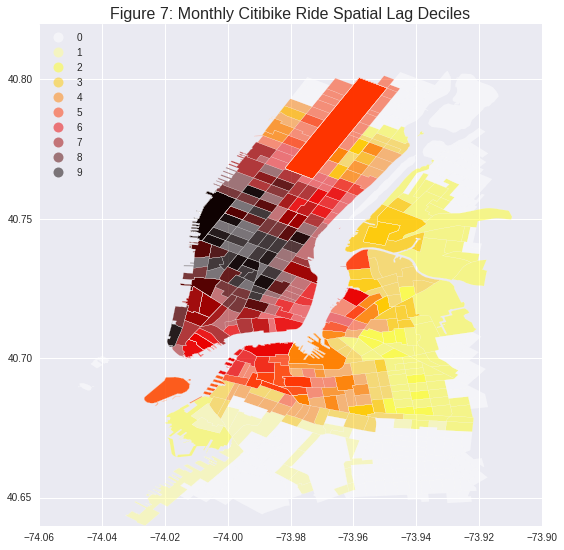

In [99]:
f, ax = plt.subplots(figsize = (9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl = MonthlyRideLagQ10.yb).plot(column = 'cl', categorical = True, 
        k = 10, cmap = 'hot_r', linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
plt.title("Figure 7: Monthly Citibike Ride Spatial Lag Deciles", fontsize = 16)

## Figure 7:
### The map above shows spatial lag of average monthly Citibike rides for each census tract in Manhattan and the surrounding areas from 2013 to 2016. Lag is essentially the average of the tracts around them (their 'neighboring' tracts). This data is also in the form of a heat map, where darker colors (closer to black) show higher lag in that tract while lighter colors (closer to white) show lower lag. *Something to note is a slight 'glitch' in the system that can be seen by looking at Governor's Island - it has no surrounding tracts, so it should theoretically appear white. However, because part of its census tract also includes parts of Brooklyn's mainland, its lag includes the neighboring tracts surrounding those areas, and the island itself is show with the same colored lag.* Generally, lag is highest in southern midtown Manhattan, and decreases out in Queens, Brooklyn, and northern Manhattan. 

## Global  Spatial Autocorrelation

In [56]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

### Moran Scatterplot

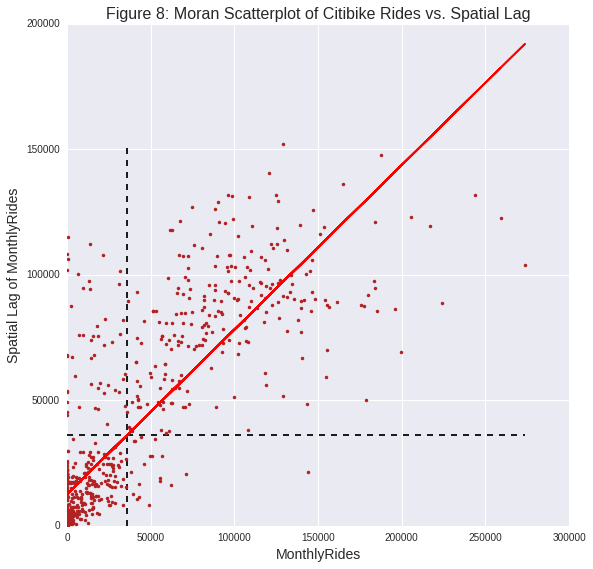

In [101]:
f, ax = plt.subplots(1, figsize = (9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color = 'firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle = '--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b * MonthlyRide, 'r')
plt.title('Figure 8: Moran Scatterplot of Citibike Rides vs. Spatial Lag', fontsize = 16)
plt.ylabel('Spatial Lag of Monthly Rides', fontsize = 14)
plt.xlabel('Monthly Rides', fontsize = 14)

## Figure 8:
### The plot above shows a Moran scatterplot of monthly Citibike rides vs. its spatial lag. Each dot represents a census tract (its own monthly average rides plotted against its corresponding lag, or the average of its neighbors). The dashed black gridlines show the Moran divisions - the upper right being tracts with high ridership and neighbors with high ridership; the upper left being tracts with lower ridership but neighbors with high ridership; the lower left being tracts with both low ridership and neighbors with low ridership, and the lower right being tracts with high ridership but neighbors with low ridership. The red line is a line of best fit, or Moran's I. It is clear that many tracts are clustering in the lower left box (near zero), and others are less dense but clearly trending in the upper right box. The best fit line supports this, going through both of these boxes and indicating that tracts with high ridership tend to also have neighboring tracts with high ridership, and tracts with lower ridership tend to have neighboring tracts with low ridership; a positive correlation between rides and lag. 

### Moran's I

In [58]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [59]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

### The two values above represent, respectively: Moran's I (or loosely the best fit line) and the p-value, which tells how significant I is (or how likely this line is to occur vs. a random line). 

### Thus, the I statistic is 0.656 for this data, and has a very small p value. 

In [60]:
I_MonthlyRide.sim[0:10]

array([ 0.00340814,  0.01626768, -0.01352693, -0.02699774, -0.02241804,
       -0.00146228, -0.02364092, -0.00461942, -0.00492843,  0.03912603])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [61]:
plt.rcParams['figure.figsize'] = (14,3)

(-0.7, 0.7)

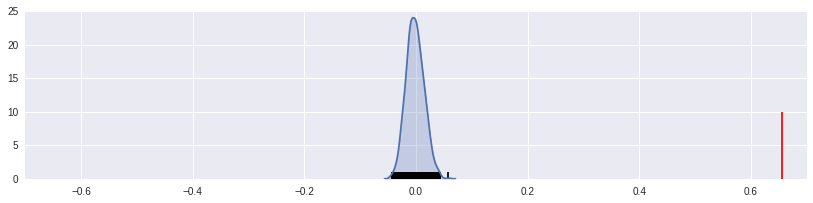

In [62]:
sns.kdeplot(I_MonthlyRide.sim, shade = True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

### Because the red line above (our I statistic) is very far from the KDE plot (which shows the expected density of observations after many repeats), we can see visually that our I statistic is significant. Thus, the trend in the Moran scatterplot above and its conclusions are significant.

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

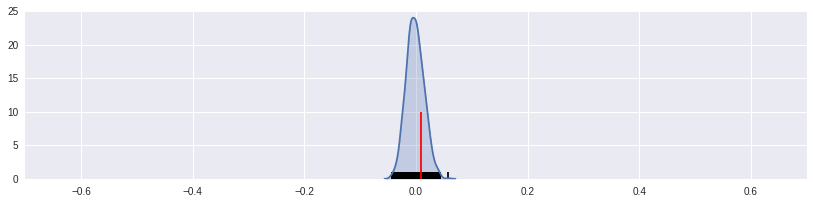

In [63]:
sns.kdeplot(I_MonthlyRide.sim, shade = True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI + .01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

### Like the Moran analysis above, but here we're looking at individual census tracts instead of all at once. In other words, it will tell us if an individual census tract is a significant hotspot or not.

In [64]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT, permutations=999)

In [65]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.177,  0.387,  0.419,  0.456]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [66]:
# Here we set the significant levels for the individual tracts and their neighboring tracts, 
# both for significant and insignificant p-values
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

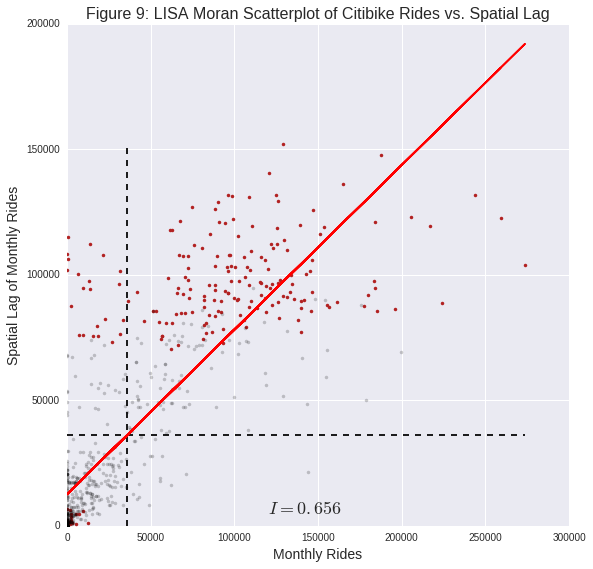

In [103]:
f, ax = plt.subplots(figsize = (9, 9))
plt.plot(sigs, W_sigs, '.', color = 'firebrick')
plt.plot(insigs, W_insigs, '.k', alpha = .2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x = 120000, y = 5000, fontsize = 18)

# dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle = '--')
# dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle = '--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b * MonthlyRide, 'r')
plt.title('Figure 9: LISA Moran Scatterplot of Citibike Rides vs. Spatial Lag', fontsize = 16)
plt.ylabel('Spatial Lag of Monthly Rides', fontsize = 14)
plt.xlabel('Monthly Rides', fontsize = 14)


## Figure 9:
### The above plot shows the same Moran Scatterplot as in Figure 8, but from the LISA analysis we are able to highlight which census tracts are significant or not. The red points indicate that the tract is a significant hot (or cold) spot, while the lighter gray dots are not significant. We can see that the significant census tracts include those were neighborinng rides was above about 75000 a month, regardless of the individual tract's number rides. Also, it seems several tracts with lower rides and lower lag were significant cold spots. From this it would seem that high lag leads to a census tract's Moran scatter location to be more significant.

### Hot and Cold spots 

In [69]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q == 1 * sig
coldspots = LMo_MonthlyRide.q == 3 * sig
print ("Number of Hotspots:", hotspots.sum())
print ("Number of Coldspots:", coldspots.sum())

Number of Hotspots: 190
Number of Coldspots: 232


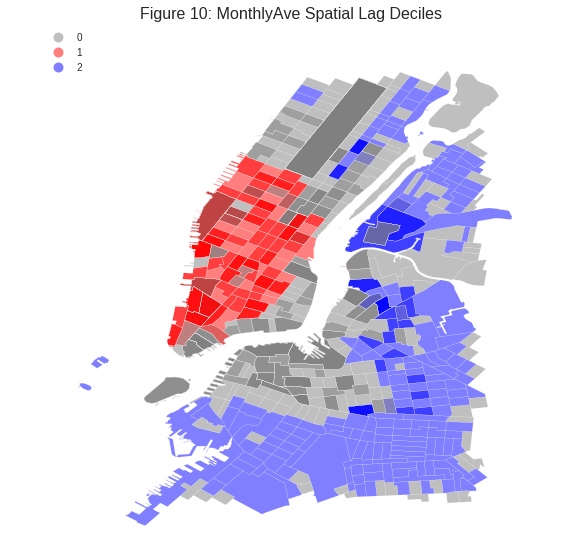

In [105]:
hcmap = colors.ListedColormap(['grey', 'red', 'blue'])
hotcold = hotspots * 1 + coldspots * 2

f, ax = plt.subplots(figsize = (9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl = hotcold).plot(column = 'cl', categorical = True, 
        k = 10, cmap = hcmap, linewidth = 0.1, ax = ax, 
        edgecolor = 'white', legend = True)
ax.set_axis_off()
plt.title("Figure 10: MonthlyAve Spatial Lag Deciles", fontsize = 16)

## Figure 10:
### The map above shows the hot and cold spots of monthly average ride spatial lag declines for Citibike data in census tracts NYC. A hot spot (in red) indicates an area where both the census tract and its neighboring tracts have high ridership. A cold spot (in blue) indicates an area where both the census tract and its neighboring tracts have low ridership. The darker of these respective colors shows a greater significance (or correlation) as a hot/coldspot. From this map, it seems the hotspots trend in southern Manhattan (and moreso along the western shore than the east), whereas cold spots trend moreso in Queens along the East River and in more central areas in Brooklyn. 